In [1]:
import pandas as pd
import geopandas as gpd
import shapely.geometry
from shapely import wkt
import fiona
import matplotlib.pyplot as plt

https://hub.arcgis.com/datasets/6996f03a1b364dbab4008d99380370ed_0/explore?location=0.969507%2C1.535162%2C1.73

In [3]:
world = gpd.read_file("data/World_Cities.geojson")

In [4]:
world

,FID,OBJECTID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,PORT_ID,LABEL_FLAG,POP_SOURCE,geometry
0,1,1,Cuiaba,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",0,0,UN_Data_2010_2020,POINT (-56.09300 -15.61500)
1,2,2,Brasilia,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",0,0,UN_Data_2010_2020,POINT (-47.89775 -15.79211)
2,3,3,Goiania,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",0,0,UN_Data_2010_2020,POINT (-49.25500 -16.72700)
3,4,4,Campo Grande,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",0,0,UN_Data_2010_2020,POINT (-54.61600 -20.45100)
4,5,5,Pedro Juan Caballero,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,0,0,,POINT (-55.74800 -22.53300)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,Greymouth,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,55440,0,,POINT (171.20700 -42.47200)
2536,2537,2537,Christchurch,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",0,0,UN_Data_2010_2020,POINT (172.63800 -43.52400)
2537,2538,2538,Dunedin,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",55370,0,UN_Data_2010_2020,POINT (170.47400 -45.88400)
2538,2539,2539,Invercargill,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,0,0,,POINT (168.37300 -46.41300)


In [5]:
#pop = pd.read_csv("processed/World_Cities_updated_0.3_Ezra.csv")[["FID","POP_updated","POP_updated_year"]]
pop = pd.read_csv("processed/World_Cities_updated_Ezra_PHD.csv")[["FID","CITY_NAME","POP_updated","POP_updated_year"]]

In [6]:
pop

,FID,CITY_NAME,POP_updated,POP_updated_year
0,1,Cuiaba,650877.0,2022.0
1,2,Brasilia,2817381.0,2022.0
2,3,Goiania,1555626.0,2021.0
3,4,Campo Grande,916001.0,2021.0
4,5,Pedro Juan Caballero,127437.0,2021.0
...,...,...,...,...
2535,2536,Greymouth,8320.0,2022.0
2536,2537,Christchurch,377900.0,2022.0
2537,2538,Dunedin,102400.0,2022.0
2538,2539,Invercargill,49800.0,2022.0


In [7]:
# pop has updated city name so drop from world
world = world.drop(columns=["CITY_NAME"])

In [8]:
# Convert the columns to integers while handling NaN values appropriately
pop['POP_updated'] = pd.to_numeric(pop['POP_updated'], errors='coerce').astype('Int64')  # 'Int64' allows for NaN in integer columns
pop['POP_updated_year'] = pd.to_numeric(pop['POP_updated_year'], errors='coerce').astype('Int64')

In [9]:
world = world.merge(pop, on="FID", how="left")

In [10]:
world['capital'] = world['STATUS'].apply(lambda x: 1 if 'national' in x.lower() else 0)

In [11]:
world

,FID,OBJECTID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,PORT_ID,LABEL_FLAG,POP_SOURCE,geometry,CITY_NAME,POP_updated,POP_updated_year,capital
0,1,1,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",0,0,UN_Data_2010_2020,POINT (-56.09300 -15.61500),Cuiaba,650877,2022,0
1,2,2,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",0,0,UN_Data_2010_2020,POINT (-47.89775 -15.79211),Brasilia,2817381,2022,1
2,3,3,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",0,0,UN_Data_2010_2020,POINT (-49.25500 -16.72700),Goiania,1555626,2021,0
3,4,4,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",0,0,UN_Data_2010_2020,POINT (-54.61600 -20.45100),Campo Grande,916001,2021,0
4,5,5,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,0,0,,POINT (-55.74800 -22.53300),Pedro Juan Caballero,127437,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,55440,0,,POINT (171.20700 -42.47200),Greymouth,8320,2022,0
2536,2537,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",0,0,UN_Data_2010_2020,POINT (172.63800 -43.52400),Christchurch,377900,2022,0
2537,2538,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",55370,0,UN_Data_2010_2020,POINT (170.47400 -45.88400),Dunedin,102400,2022,0
2538,2539,2539,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,0,0,,POINT (168.37300 -46.41300),Invercargill,49800,2022,0


In [12]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
layers = fiona.listlayers("data/World_Water_Bodies/v107/hydropolys.gdb")

In [14]:
layers

['hydropolys']

https://hub.arcgis.com/content/e750071279bf450cbd510454a80f2e63/about

In [15]:
water = gpd.read_file("data/World_Water_Bodies/v107/hydropolys.gdb", layer="hydropolys")

In [16]:
water.head()

,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,geometry
0,,,,Inland intermittent,,0.084017,0.000161,"MULTIPOLYGON (((33.36209 -3.57682, 33.36398 -3..."
1,,,,Inland intermittent,,0.122991,0.000206,"MULTIPOLYGON (((13.74117 5.63882, 13.74251 5.6..."
2,,,,Inland intermittent,,0.039491,0.000059,"MULTIPOLYGON (((35.91590 13.69591, 35.91485 13..."
3,,,,Inland intermittent,,0.109760,0.000323,"MULTIPOLYGON (((-9.91448 15.94434, -9.91341 15..."
4,,,,Inland intermittent,AE,0.014541,0.000012,"MULTIPOLYGON (((53.83962 23.96135, 53.83979 23..."


In [17]:
water.TYPE.unique()

array(['Inland intermittent', 'Dry salt flat', 'Inland perennial',
       'Inundated area', 'Ocean or Sea'], dtype=object)

In [18]:
len(water)

2804476

In [19]:
# reproject to a projected CRS for distance calculations
projected_crs = 'EPSG:3857'  # Web Mercator projection
world = world.to_crs(projected_crs)
water = water.to_crs(projected_crs)

In [20]:
sea = water[water.TYPE=="Ocean or Sea"]

In [21]:
sea

,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,geometry
2259631,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4877301.695, 6927..."
2259632,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4851761.271, 6927..."
2259633,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4826286.285, 6927..."
2259634,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4800876.165, 6927..."
2259635,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4980129.435, 6927..."
...,...,...,...,...,...,...,...,...
2804471,Caribbean Sea,Atlantic Ocean,,Ocean or Sea,,1.403653,0.053397,"MULTIPOLYGON (((-9627396.587 2403060.791, -965..."
2804472,Chukchi Sea,Arctic Ocean,,Ocean or Sea,,8.718282,0.324807,"MULTIPOLYGON (((-19663246.045 11598683.756, -1..."
2804473,Arctic Ocean,,,Ocean or Sea,,18.096119,16.604523,"MULTIPOLYGON (((-19480910.889 11825048.646, -1..."
2804474,Pacific Ocean,,,Ocean or Sea,,0.997544,0.020219,"MULTIPOLYGON (((20034568.967 -1866133.486, 200..."


In [22]:
# the nearest spatial join: https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html
nearest = gpd.sjoin_nearest(world, water, how='inner', lsuffix='_city', rsuffix='_water', distance_col='distance_water')

In [23]:
nearest

,FID,OBJECTID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,capital,index__water,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,distance_water
0,1,1,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",...,0,58201,,,,Inland perennial,BR,5.444046,0.002805,903.914063
1,2,2,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",...,1,2218993,Lago do Paranoá,,,Inland perennial,BR,0.811637,0.002991,4012.810793
2,3,3,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",...,0,57486,,,,Inland perennial,BR,0.028151,0.000023,15550.003073
3,4,4,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",...,0,54367,,,,Inland perennial,BR,0.012474,0.000008,17118.757659
4,5,5,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,...,0,53738,,,,Inland perennial,BR,0.012653,0.000008,14526.045735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,...,0,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2525.251905
2536,2537,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",...,0,1337742,,,,Inland perennial,NZ,0.108650,0.000227,6979.020064
2537,2538,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",...,0,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3592.055812
2538,2539,2539,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,...,0,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3846.671324


In [24]:
nearest = gpd.sjoin_nearest(nearest, sea[['Name1','Name2','Name3','TYPE','ISO_CC','SHAPE_Length','SHAPE_Area','geometry']], how='inner', lsuffix='_waterbody', rsuffix='_sea', distance_col='distance_sea')

In [25]:
nearest

,FID,OBJECTID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,distance_water,index__sea,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea
0,1,1,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",...,903.914063,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,1.420019e+06
1,2,2,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",...,4012.810793,2483520,Atlantic Ocean,,,Ocean or Sea,,1.040116,0.007083,9.292546e+05
2,3,3,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",...,15550.003073,2776415,Atlantic Ocean,,,Ocean or Sea,,0.422189,0.004244,9.069651e+05
3,4,4,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",...,17118.757659,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.835995e+05
4,5,5,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,...,14526.045735,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.529278e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,...,2525.251905,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252e+03
2536,2537,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",...,6979.020064,2353820,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012e+03
2537,2538,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",...,3592.055812,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056e+03
2538,2539,2539,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,...,3846.671324,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3.846671e+03


In [26]:
nearest = nearest.drop_duplicates(subset=['FID'])

In [27]:
nearest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2540 entries, 0 to 2539
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   FID                      2540 non-null   int64   
 1   OBJECTID                 2540 non-null   int64   
 2   GMI_ADMIN                2540 non-null   object  
 3   ADMIN_NAME               2540 non-null   object  
 4   FIPS_CNTRY               2540 non-null   object  
 5   CNTRY_NAME               2540 non-null   object  
 6   STATUS                   2540 non-null   object  
 7   POP                      2540 non-null   int64   
 8   POP_RANK                 2540 non-null   int64   
 9   POP_CLASS                2540 non-null   object  
 10  PORT_ID                  2540 non-null   int64   
 11  LABEL_FLAG               2540 non-null   int64   
 12  POP_SOURCE               2540 non-null   object  
 13  geometry                 2540 non-null   geometry
 14  CITY_

In [ ]:
#water[water.Name1=="Lake Michigan"]

In [28]:
nearest

,FID,OBJECTID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,distance_water,index__sea,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea
0,1,1,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",...,903.914063,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,1.420019e+06
1,2,2,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",...,4012.810793,2483520,Atlantic Ocean,,,Ocean or Sea,,1.040116,0.007083,9.292546e+05
2,3,3,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",...,15550.003073,2776415,Atlantic Ocean,,,Ocean or Sea,,0.422189,0.004244,9.069651e+05
3,4,4,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",...,17118.757659,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.835995e+05
4,5,5,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,...,14526.045735,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.529278e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,...,2525.251905,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252e+03
2536,2537,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",...,6979.020064,2353820,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012e+03
2537,2538,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",...,3592.055812,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056e+03
2538,2539,2539,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,...,3846.671324,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3.846671e+03


In [29]:
# convert distances from meters to kilometers
nearest['distance_water'] = nearest['distance_water'] / 1000  # Convert to kilometers

/Users/mengcai/opt/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
# convert distances from meters to kilometers
nearest['distance_sea'] = nearest['distance_sea'] / 1000  # Convert to kilometers

In [31]:
df = nearest.drop(columns=['OBJECTID','PORT_ID','LABEL_FLAG'])

In [32]:
def rank_population(pop):
    if pd.isna(pop): # no population data
        return 0
    elif pop >= 5000000:
        return 1
    elif 1000000 <= pop < 5000000:
        return 2
    elif 500000 <= pop < 1000000:
        return 3
    elif 250000 <= pop < 500000:
        return 4
    elif 100000 <= pop < 250000:
        return 5
    elif 50000 <= pop < 100000:
        return 6
    else:
        return 7

In [33]:
df['POP_updated'] = pd.to_numeric(df['POP_updated'], errors='coerce')
df['POP_rank_updated'] = df['POP_updated'].apply(rank_population)

In [34]:
# fill in empty population cells with 0
pop['POP_updated'] = pop['POP_updated'].fillna(0)

In [35]:
df

,FID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,POP_SOURCE,...,index__sea,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated
0,1,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",UN_Data_2010_2020,...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,1420.018591,3
1,2,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",UN_Data_2010_2020,...,2483520,Atlantic Ocean,,,Ocean or Sea,,1.040116,0.007083,929.254581,2
2,3,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",UN_Data_2010_2020,...,2776415,Atlantic Ocean,,,Ocean or Sea,,0.422189,0.004244,906.965140,2
3,4,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",UN_Data_2010_2020,...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,883.599543,3
4,5,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,,...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,852.927751,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,,...,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252,7
2536,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",UN_Data_2010_2020,...,2353820,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012,4
2537,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",UN_Data_2010_2020,...,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056,5
2538,2539,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,,...,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3.846671,7


In [36]:
df.POP_rank_updated.value_counts()

POP_rank_updated
7    669
5    510
6    364
4    355
3    269
2    266
1     58
0     49
Name: count, dtype: int64

In [37]:
## to modify later - remove cities without population data and is not the capital 
#df = df[~((df.capital==0)&(df.POP_rank_updated==0))] 

In [38]:
# define a mapping for POP_RANK to radius thresholds
thresholds = {
    1: 40, # 5,000,000 and greater
    2: 30, # 1,000,000 to 4,999,999
    3: 20, # 500,000 to 999,999
    4: 15, # 250,000 to 499,999
    5: 10, # 100,000 to 249,999
    6: 8, # 50,000 to 99,999
    7: 5, # Less than 50,000
    0: 5 #  no population data # row removed so the number does not matter
}

In [39]:
# Function to determine 'type' based on POP_RANK and distance to the sea/ocean
def determine_type(row):
    pop_rank = row['POP_rank_updated']
    distance = row['distance_sea']
    
    # Get the corresponding radius for the city's pop_rank
    threshold = thresholds.get(pop_rank)
    
    # Check if distance to coast is less than the threshold
    if distance < threshold:
        return 'coast'
    else:
        return 'inland'

In [40]:
df['city_type'] = df.apply(determine_type, axis=1)

In [41]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2540 entries, 0 to 2539
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   FID                      2540 non-null   int64   
 1   GMI_ADMIN                2540 non-null   object  
 2   ADMIN_NAME               2540 non-null   object  
 3   FIPS_CNTRY               2540 non-null   object  
 4   CNTRY_NAME               2540 non-null   object  
 5   STATUS                   2540 non-null   object  
 6   POP                      2540 non-null   int64   
 7   POP_RANK                 2540 non-null   int64   
 8   POP_CLASS                2540 non-null   object  
 9   POP_SOURCE               2540 non-null   object  
 10  geometry                 2540 non-null   geometry
 11  CITY_NAME                2540 non-null   object  
 12  POP_updated              2491 non-null   Int64   
 13  POP_updated_year         2491 non-null   Int64   
 14  capit

In [42]:
#df[df['FIPS_CNTRY']=="CA"]
us = df[df['FIPS_CNTRY']=="US"] 

In [43]:
us[us.CITY_NAME=="Chicago"]

,FID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,POP_SOURCE,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
495,496,USA-ILL,Illinois,US,United States,Other,2693976,2,"1,000,000 to 4,999,999",US_Census_2019,...,Chesapeake Bay,Atlantic Ocean,,Ocean or Sea,,0.039096,0.000026,1243.559923,2,inland


In [44]:
#us

<Axes: >

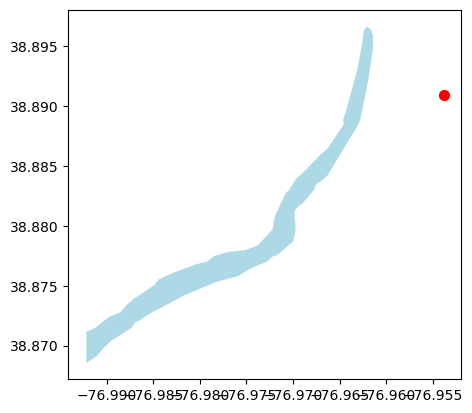

In [45]:
fig, ax = plt.subplots()
sea[sea.index==2487003].to_crs(epsg=4326).plot(ax=ax,color="lightblue")
us[us.capital==1].to_crs(epsg=4326).plot(ax=ax, color="red", marker="o", markersize=50)

In [46]:
df[df.city_type=="coast"]

,FID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,POP_SOURCE,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
15,16,WLF,Wallis & Futuna,WF,Wallis & Futuna,National and provincial capital,0,0,,,...,Pacific Ocean,,,Ocean or Sea,,1.652176,0.055174,0.018889,3,coast
16,17,WSM,Samoa,WS,Samoa,National capital,37391,7,"Less than 50,000",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,1.146609,0.045098,0.000000,7,coast
17,18,ASM,American Samoa,AQ,American Samoa,National and provincial capital,3656,7,"Less than 50,000",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,2.595805,0.050280,0.302533,7,coast
18,19,PYF,French Polynesia,FP,French Polynesia,National and provincial capital,25763,7,"Less than 50,000",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,1.182310,0.049963,0.052122,7,coast
19,20,NIU,Niue,NE,Niue,National and provincial capital,639,7,"Less than 50,000",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,1.181183,0.043316,0.826935,7,coast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,NZL-NMR,Nelson-Marlborough,NZ,New Zealand,Provincial capital,0,0,,,...,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.990741,0.036365,2.627987,6,coast
2535,2536,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,,...,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252,7,coast
2536,2537,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012,4,coast
2537,2538,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056,5,coast


In [47]:
list(df)

['FID',
 'GMI_ADMIN',
 'ADMIN_NAME',
 'FIPS_CNTRY',
 'CNTRY_NAME',
 'STATUS',
 'POP',
 'POP_RANK',
 'POP_CLASS',
 'POP_SOURCE',
 'geometry',
 'CITY_NAME',
 'POP_updated',
 'POP_updated_year',
 'capital',
 'index__water',
 'Name1__waterbody',
 'Name2__waterbody',
 'Name3__waterbody',
 'TYPE__waterbody',
 'ISO_CC__waterbody',
 'SHAPE_Length__waterbody',
 'SHAPE_Area__waterbody',
 'distance_water',
 'index__sea',
 'Name1__sea',
 'Name2__sea',
 'Name3__sea',
 'TYPE__sea',
 'ISO_CC__sea',
 'SHAPE_Length__sea',
 'SHAPE_Area__sea',
 'distance_sea',
 'POP_rank_updated',
 'city_type']

In [48]:
df[df.FIPS_CNTRY=="CA"]

,FID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,POP_SOURCE,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
172,173,CAN-NTR,Northwest Territories,CA,Canada,Provincial capital,0,0,,,...,Arctic Ocean,,,Ocean or Sea,,17.746483,0.360755,1278.313223,7,inland
180,181,CAN-YTR,Yukon Territory,CA,Canada,Provincial capital,0,0,,,...,Pacific Ocean,,,Ocean or Sea,,0.063611,0.000108,276.631717,7,inland
185,186,CAN-ALB,Alberta,CA,Canada,Provincial capital,1025096,2,"1,000,000 to 4,999,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,0.259876,0.001258,1274.190700,2,inland
186,187,CAN-ALB,Alberta,CA,Canada,Other,1335145,2,"1,000,000 to 4,999,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,0.259876,0.001258,1018.529338,2,inland
187,188,CAN-BCL,British Columbia,CA,Canada,Other,685885,3,"500,000 to 999,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,0.877933,0.003891,2.282771,2,coast
188,189,CAN-BCL,British Columbia,CA,Canada,Provincial capital,94005,6,"50,000 to 99,999",UN_Data_2010_2020,...,Pacific Ocean,,,Ocean or Sea,,1.668916,0.048855,1.274780,4,coast
192,193,CAN-NTR,Northwest Territories,CA,Canada,Other,0,0,,,...,Beaufort Sea,Arctic Ocean,,Ocean or Sea,,19.616296,0.266666,116.709625,7,inland
194,195,CAN-MNT,Manitoba,CA,Canada,Other,0,0,,,...,Hudson Bay,Arctic Ocean,,Ocean or Sea,,0.993266,0.041549,4.377646,7,coast
195,196,CAN-SSK,Saskatchewan,CA,Canada,Other,275242,4,"250,000 to 499,999",UN_Data_2010_2020,...,Hudson Bay,Arctic Ocean,,Ocean or Sea,,0.321527,0.007033,1835.039577,4,inland
196,197,CAN-SSK,Saskatchewan,CA,Canada,Provincial capital,237011,5,"100,000 to 249,999",UN_Data_2010_2020,...,Hudson Bay,Arctic Ocean,,Ocean or Sea,,0.321527,0.007033,1834.262098,5,inland


In [52]:
df.to_csv("processed/full_calculation_20241117.csv", index=False)

In [50]:
result_rows = []

for country_code, group in df.groupby('FIPS_CNTRY'):
    
    # Find the capital city in the group
    capital_cities = group[group['capital']==1]
    
    if capital_cities.empty:
        continue  # No capital city in this country

    capital_city = capital_cities.iloc[0]

    capital_type = capital_city['city_type']

    # Determine the type of city to find
    if capital_type == 'inland':
    # Need to find a coast city
        candidate_cities = group[group['city_type'] != 'inland']
    else: # sea
    # Need to find a inland city
        candidate_cities = group[group['city_type'] == 'inland']
       
    # Exclude the capital city from candidate cities
    candidate_cities = candidate_cities[candidate_cities['CITY_NAME'] != capital_city['CITY_NAME']]

    if candidate_cities.empty:
        # No suitable second city, just keep the capital city
        result_rows.append(capital_city)
    else:
        # Find the city with the closest population to the capital
        candidate_cities = candidate_cities.copy()
        candidate_cities['pop_diff'] = (candidate_cities['POP_updated'] - capital_city['POP_updated']).abs()

        # Get the city with the smallest population difference
        second_city = candidate_cities.loc[candidate_cities['pop_diff'].idxmin()]

        # Append both capital city and second city
        result_rows.extend([capital_city, second_city])

# Create the result dataframe
result = gpd.GeoDataFrame(result_rows, crs=projected_crs)

In [51]:
result

,FID,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,POP_SOURCE,...,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type,pop_diff
295,296,ABW,Aruba,AA,Aruba,National and provincial capital,28295,7,"Less than 50,000",UN_Data_2010_2020,...,Atlantic Ocean,,Ocean or Sea,,1.283472,0.053652,1.449000,6,coast,NaN
1555,1556,ATG,Antigua & Barbuda,AC,Antigua & Barbuda,National capital,0,0,,,...,Atlantic Ocean,,Ocean or Sea,,1.896968,0.045993,0.684450,5,coast,NaN
2256,2257,ARE-AZA,Abu Zaby,AE,United Arab Emirates,National and provincial capital,1539000,2,"1,000,000 to 4,999,999",UN_Habitat_2020,...,Indian Ocean,,Ocean or Sea,,3.565310,0.047519,2.347458,2,coast,NaN
1071,1072,AFG-KAB,Kabol,AF,Afghanistan,National and provincial capital,4136000,2,"1,000,000 to 4,999,999",UN_Habitat_2020,...,Indian Ocean,,Ocean or Sea,,0.702247,0.009304,1192.107975,2,inland,NaN
1909,1910,DZA-ALG,Alger,AG,Algeria,National and provincial capital,3608000,2,"1,000,000 to 4,999,999",UN_Habitat_2020,...,Atlantic Ocean,,Ocean or Sea,,1.359198,0.047538,1.553963,2,coast,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457,2458,SWZ-HHH,Hhohho,WZ,Eswatini,National capital,0,0,,,...,,,Ocean or Sea,,0.553750,0.010466,157.163254,6,inland,NaN
864,865,YEM-SAN,San'a',YM,Yemen,National and provincial capital,3820000,2,"1,000,000 to 4,999,999",UN_Habitat_2020,...,Indian Ocean,,Ocean or Sea,,1.752070,0.069197,149.616375,7,inland,NaN
865,866,YEM-AHD,Al Hudaydah,YM,Yemen,Provincial capital,0,0,,,...,Indian Ocean,,Ocean or Sea,,1.752070,0.069197,0.594437,4,coast,349878.0
2381,2382,ZMB-LUS,Lusaka,ZA,Zambia,National and provincial capital,1747152,2,"1,000,000 to 4,999,999",UN_Data_2010_2020,...,,,Ocean or Sea,,0.521008,0.008197,897.500478,5,inland,NaN


In [53]:
result.to_csv("processed/selected_cities_20241117.csv", index=False)